In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as patches
import seaborn as sns
import datetime as dt
from IPython.display import HTML
import os
plt.rcParams['animation.ffmpeg_path'] = '../ffmpeg.exe'

In [18]:
class Params():
    def __init__(self):
        self.pop_size = 100
        self.age_mean = 46
        self.age_std = 13
        self.age_min = 0
        self.age_max = 99
        
        self.colors = ["#59BFFF", "#FC6A03", "#E3242B", "#7C5295", "#028A0F", "#1B1E23"]
        # Minimum of 25
        self.num_of_frames = 300
        self.x_min = 0
        self.x_max = 1
        self.x_min_bound = 0.02
        self.x_max_bound = 0.98
        self.y_min = 0
        self.y_max = 1
        self.y_min_bound = 0.02
        self.y_max_bound = 0.98
        # Rate of infectiousness
        self.morbidity_rate = 1
        # Rate at which each age group becomes symptomatic
        self.symptomatic_rate = {
            0 : 0.6,
            1 : 0.6,
            2 : 0.65,
            3 : 0.7,
            4 : 0.7,
            5 : 0.75,
            6 : 0.8,
            7 : 0.85,
            8 : 0.9,
            9 : 0.95
        }
        # Rate at which each age group dies from their symptoms
        self.mortality_rate = {
            0 : 0.05,
            1 : 0.05,
            2 : 0.01,
            3 : 0.03,
            4 : 0.05,
            5 : 0.10,
            6 : 0.12,
            7 : 0.15,
            8 : 0.18,
            9 : 0.20
        }
        self.incubation_period = 21
        self.symptomatic_period = 21
        self.infectious_after_immunity = 6
        self.hospital_capacity = 50
        
        self.save_folder = "C:/Users/ParthivNaresh/Pandemic-Simulations/Outputs/"

In [3]:
def initialize(pm):
    population = pd.DataFrame()

    population["id"] = pd.Series([x for x in range(pm.pop_size)])
    population["current_x"] = np.random.uniform(0, 1, pm.pop_size)
    population["current_x"] = np.clip(population["current_x"], pm.x_min_bound, pm.x_max_bound)
    population["current_y"] = np.random.uniform(0, 1, pm.pop_size)
    population["current_y"] = np.clip(population["current_y"], pm.y_min_bound, pm.y_max_bound)
    population["age"] = np.random.normal(pm.age_mean, pm.age_std, size = pm.pop_size)
    population["age"] = np.clip(round(population["age"]), pm.age_min, pm.age_max)
    population["age"] = population["age"].astype(int)
    # 0 for healthy, 1 for infected-asymptomatic, 2 for infected-symptomatic,
    # 3 for immune-infectious, 4 for immune-noninfectious, 5 for dead 
    population["state"] = pd.Series(0 for x in range(pm.pop_size))
    population["state_color"] = [pm.colors[each] for each in population["state"]]
    population["frames_since_infected"] = pd.Series(0 for x in range(pm.pop_size))
    population["frames_since_symptomatic"] = pd.Series(0 for x in range(pm.pop_size))
    population["frames_since_immune"] = pd.Series(0 for x in range(pm.pop_size))
    population["first_destiny"] = pd.Series(0 for x in range(pm.pop_size))
    population["second_destiny"] = pd.Series(0 for x in range(pm.pop_size))

    #data.insert(data.columns.get_loc("state"), "Age", np.random.normal(size=2000), True)
    
    return population


In [4]:
# Returns a 100 x 100 numpy array with a "human_state" (usually 1 for infected)
# for every grid that contains a person in that state and in every grid adjacent.
def identify_matrix(population, human_state):
    matrix = [[0 for each in range(100)] for each in range(100)]
    matrix = np.array(matrix)
    #print(danger_matrix)
    for ind, infected in population[population["state"] == human_state].iterrows():
        x_coordinate = int(100*infected["current_x"])
        y_coordinate = int(100*infected["current_y"])
        #print(x_coordinate, y_coordinate)
        #if (x_coordinate)
        matrix[len(matrix)-1-y_coordinate][x_coordinate] = human_state
        # One below
        matrix[len(matrix)-y_coordinate][x_coordinate] = human_state
        # One above
        matrix[len(matrix)-2-y_coordinate][x_coordinate] = human_state
        # One left
        matrix[len(matrix)-1-y_coordinate][x_coordinate-1] = human_state
        # One right
        matrix[len(matrix)-1-y_coordinate][x_coordinate+1] = human_state
        # Bottom left
        matrix[len(matrix)-y_coordinate][x_coordinate-1] = human_state
        # Bottom right
        matrix[len(matrix)-y_coordinate][x_coordinate+1] = human_state
        # Top left
        matrix[len(matrix)-2-y_coordinate][x_coordinate-1] = human_state
        # Top right
        matrix[len(matrix)-2-y_coordinate][x_coordinate+1] = human_state
    return matrix

In [5]:
# Returns a list of people of "people_state" sharing the same location in the grid
# marked with "matrix_state".
# e.g. return all the healthy people within infected zones
# people_within_matrix(population, infection_matrix, 0, 1)
def people_within_matrix(population, matrix, people_state, matrix_state):
    people_in_zone = []
    for index, person in population[population["state"] == people_state].iterrows():
        x_coordinate = int(100*person["current_x"])
        y_coordinate = int(100*person["current_y"])
        try:
            if (matrix[len(matrix)-1-y_coordinate][x_coordinate] == matrix_state or 
                matrix[len(matrix)-y_coordinate][x_coordinate] == matrix_state or 
                matrix[len(matrix)-2-y_coordinate][x_coordinate] == matrix_state or 
                matrix[len(matrix)-1-y_coordinate][x_coordinate-1] == matrix_state or 
                matrix[len(matrix)-1-y_coordinate][x_coordinate+1] == matrix_state or 
                matrix[len(matrix)-y_coordinate][x_coordinate-1] == matrix_state or 
                matrix[len(matrix)-y_coordinate][x_coordinate+1] == matrix_state or 
                matrix[len(matrix)-2-y_coordinate][x_coordinate-1] == matrix_state or 
                matrix[len(matrix)-2-y_coordinate][x_coordinate+1] == matrix_state):
                people_in_zone.append(person["id"])
        except:
            print(f'Person {index} out of bounds at', person["current_x"], person["current_y"])
    return people_in_zone

In [6]:
# Rolls the dice on infecting healthy people surrounding an infected
# person (aymptomatic or symptomatic) or an immune person (infectious).
def infect(population, params, infected_from_state):
    infection_matrix = identify_matrix(population, infected_from_state)
    exposed_people = people_within_matrix(population, infection_matrix, 0, infected_from_state)
    # Roll the dice on whether a person will get sick based on the morbidity rate.
    for exposed_person in exposed_people:
        if (np.random.random() < params.morbidity_rate):
                population.at[exposed_person, "state"] = 1
                population.at[exposed_person, "state_color"] = params.colors[1]
    
    return population
#pm = Params()
#pop = initialize(pm)
#infection_matrix(pop, pm)

In [7]:
def incubation_determination(population, params):
    # Assign an initial destiny of infected-symptomatic or immune-uninfectious
    # to everyone who has been infected-asymptomatic for at least one frame.
    population = assign_destiny(population, params)
    # Symptomize anyone asymptomatic who is destined to become symptomatic
    population = symptomize(population, params)
    # Immunize anyone asymptomatic who has lasted the incubation period
    population = immunize(population, params)
    # Kill anyone symptomatic who is destined to die
    population = kill(population, params)
    
    return population

In [8]:
def assign_destiny(population, params):
    # Population of newly infected-asymptomatic people
    new_infected = population[(population.frames_since_infected==1) & 
                          (population.state==1)]
    # A series of probabilities determining whether a person will be symptomatic
    # within the incubation period based on their age.
    symp_rate_by_age = ((new_infected["age"]/10).astype(int)).apply(lambda age: params.symptomatic_rate.get(age))
    # All newly infected people are iterated over and assigned a destiny based on
    # their likelihood of becoming symptomatic.
    for ind, rate in zip(symp_rate_by_age.index.values, symp_rate_by_age):
        if (np.random.random() <= rate):
            population.at[ind, "first_destiny"] = 2
        else:
            population.at[ind, "first_destiny"] = 3
    
    new_symptomatic = population[(population.frames_since_symptomatic==1) & 
                          (population.state==2)]
    death_rate_by_age = ((new_symptomatic["age"]/10).astype(int)).apply(lambda age: params.mortality_rate.get(age))
    # All newly symptomatic people are iterated over and assigned a destiny based on
    # their likelihood of dying.
    for ind, rate in zip(death_rate_by_age.index.values, death_rate_by_age):
        if (np.random.random() <= rate):
            population.at[ind, "second_destiny"] = 5
        else:
            population.at[ind, "second_destiny"] = 3
    return population

In [9]:
def symptomize(population, params):
    # Population of infected-asymptomatic people destined to be symptomatic who are
    # still within the incubation period.
    infected_asymp_early = population[(population.frames_since_infected<params.incubation_period) & 
                          (population.state==1) & (population.first_destiny==2)]
    # A sample of this population equal to the inverse of the incubation period is
    # iterated over every frame and made symptomatic.
    for ind, person_to_symp in infected_asymp_early.sample(frac=(1/params.incubation_period)).iterrows():
        population.at[ind, "state"] = 2
        population.at[ind, "state_color"] = params.colors[2]
    # Population of infected-asymptomatic people destined to be symptomatic who are
    # on the last day of the incubation period.
    infected_asymp_final = population[(population.frames_since_infected==params.incubation_period) & 
                          (population.state==1) & (population.first_destiny==2)]
    # Everyone destined to be symptomatic is made symptomatic.
    for ind, person_to_symp in infected_asymp_final.iterrows():
        population.at[ind, "state"] = 2
        population.at[ind, "state_color"] = params.colors[2]
    return population

In [10]:
def immunize(population, params):
    # Population of infected-asymptomatic people who have lasted the incubation period
    # and are destined for immunity will now become immune-infectious.
    immune_and_infectious = population[(population.frames_since_infected>params.incubation_period) & 
                          (population.state==1) & (population.first_destiny==3)]
    # Everyone destined to be immune is made immune-infectious.
    for ind, immune_person in immune_and_infectious.iterrows():
        population.at[ind, "state"] = 3
        population.at[ind, "state_color"] = params.colors[3]
    # A sample of this population equal to the inverse of the symptomatic period is
    # iterated over every frame and made immune-infectious.
    immune_and_infectious_early = population[(population.frames_since_symptomatic<params.symptomatic_period) & 
                          (population.state==2) & (population.second_destiny==3)]
    for ind, immune_person in immune_and_infectious_early.sample(frac=(1/params.symptomatic_period)).iterrows():
        population.at[ind, "state"] = 3
        population.at[ind, "state_color"] = params.colors[3]
    # Population of infectious-symptomatic people who are destined to be immune-infectious
    # on the last day of the symptomatic period. 
    immune_and_infectious_final = population[(population.frames_since_symptomatic==params.symptomatic_period) & 
                          (population.state==2) & (population.second_destiny==3)]
    for ind, immune_person in immune_and_infectious_final.iterrows():
        population.at[ind, "state"] = 3
        population.at[ind, "state_color"] = params.colors[3]
    # Everyone immune-infectious is made immune-uninfectious after 3 frames.
    immune_and_uninfectious = population[(population.frames_since_immune>params.infectious_after_immunity) & 
                          (population.state==3)]
    for ind, immune_person in immune_and_uninfectious.iterrows():
        population.at[ind, "state"] = 4
        population.at[ind, "state_color"] = params.colors[4]
    return population
    

In [11]:
def kill(population, params):
    dead_early = population[(population.frames_since_symptomatic<params.symptomatic_period) & 
                          (population.state==2) & (population.second_destiny==5)]
    # A sample of this population equal to the inverse of the incubation period is
    # iterated over every frame and made symptomatic.
    for ind, dead_person in dead_early.sample(frac=(1/params.symptomatic_period)).iterrows():
        population.at[ind, "state"] = 5
        population.at[ind, "state_color"] = params.colors[5]
    
    dead_final = population[(population.frames_since_symptomatic==params.symptomatic_period) & 
                          (population.state==2) & (population.second_destiny==5)]
    for ind, dead_person in dead_final.iterrows():
        population.at[ind, "state"] = 5
        population.at[ind, "state_color"] = params.colors[5]
    
    return population

______________________________________
Iteration time: 549.483ms
Incubation time: 624.9739999999998ms
Infect time: 1197.46ms
Move time: 26.979000000000003ms
Ax2 time: 0.0ms
Ax3 time: 0.0ms
Color time: 0.0ms
From frame 0 to 25 it took 4495.995
______________________________________
Iteration time: 479.30400000000003ms
Incubation time: 545.107ms
Infect time: 1039.7109999999998ms
Move time: 15.053999999999998ms
Ax2 time: 0.0ms
Ax3 time: 0.0ms
Color time: 0.0ms
From frame 25 to 50 it took 4044.865
______________________________________
Iteration time: 517.744ms
Incubation time: 536.0930000000001ms
Infect time: 1032.251ms
Move time: 22.28ms
Ax2 time: 0.997ms
Ax3 time: 0.0ms
Color time: 0.0ms
From frame 50 to 75 it took 4022.09
______________________________________
Iteration time: 602.4340000000001ms
Incubation time: 678.4850000000001ms
Infect time: 1403.219ms
Move time: 27.953ms
Ax2 time: 0.0ms
Ax3 time: 0.0ms
Color time: 0.0ms
From frame 75 to 100 it took 5108.668
________________________

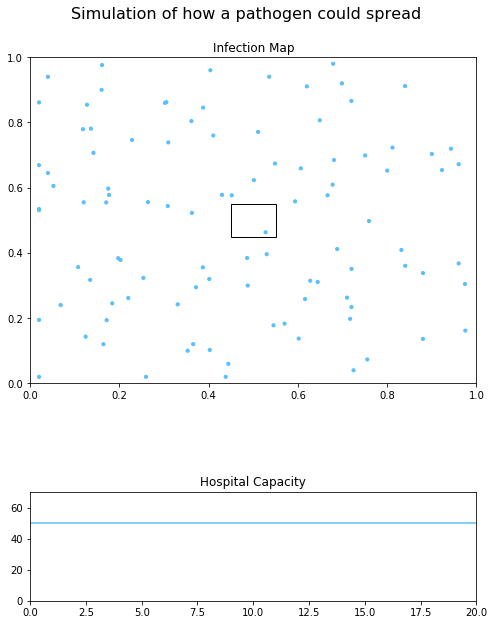

In [25]:
class Simulation():
    
    def __init__(self, *args, **kwargs):
        self.start_init = dt.datetime.now()
        self.initialize_parameters()
        self.initialize_population()
        self.initialize_movementstream()
        #self.time_df = pd.DataFrame()
        self.begin_simulation = dt.datetime.now()
        self.t_startframe = dt.datetime.now()
        self.frame_checkpoints = 0
        self.time_iteration = 0
        self.time_incubation = 0
        self.time_infect = 0
        self.time_move = 0
        self.time_ax2 = 0
        self.time_ax3 = 0
        self.time_color = 0

        self.begin_setup = dt.datetime.now()
        self.setup_fig()
        self.setup_ax1()
        self.add_destination()
        self.setup_ax1scatter()
        self.setup_ax2()
        self.setup_ax3()
        self.end_setup = dt.datetime.now()
        self.setup_time = ((self.end_setup - self.begin_setup) * 1000).total_seconds()

        self.create_animation()

        
    def initialize_parameters(self):
        self.params = Params()
    
    def initialize_population(self):
        self.population = initialize(self.params)
        
    def initialize_movementstream(self):
        self.stream = self.movement_stream()
    
    def setup_fig(self):
        self.fig = plt.figure(figsize=(8,10))
        self.fig.suptitle('Simulation of how a pathogen could spread', y=0.95, fontsize=16)
        self.grid = plt.GridSpec(8, 6, hspace=1)
    
    def setup_ax1(self):
        self.ax1 = self.fig.add_subplot(self.grid[:5,:])
        self.ax1.set_title('Infection Map', fontdict={'fontsize':12, 'color': 'black'})
        self.ax1.set_xlim((self.params.x_min, self.params.x_max))
        self.ax1.set_ylim((self.params.y_min, self.params.y_max))

    def add_destination(self):
        self.rect = patches.Rectangle((0.45,0.45),0.1,0.1,linewidth=1,edgecolor='black',facecolor='none')
        self.ax1.add_patch(self.rect)
    
    def setup_ax1scatter(self):
        self.scat = self.ax1.scatter(x = self.population["current_x"], 
                                    y = self.population["current_y"], 
                                    s = 10, c = self.population["state_color"])
    
    def setup_ax2(self):
        self.ax2 = self.fig.add_subplot(self.grid[5:6,:])
        self.text_frames = self.ax2.text(0.45, 1, "", fontsize=10)
        self.text_healthy = self.ax2.text(0, 0.5, "", fontsize=8)
        self.text_infected_a = self.ax2.text(0.35, 0.5, "", fontsize=8)
        self.text_infected_s = self.ax2.text(0.75, 0.5, "", fontsize=8)
        self.text_immune_i = self.ax2.text(0, 0, "", fontsize=8)
        self.text_immune_u = self.ax2.text(0.35, 0, "", fontsize=8)
        self.text_dead = self.ax2.text(0.75, 0, "", fontsize=8)
        self.ax2.set_axis_off()
    
    def update_ax2_stats(self, frame):
        self.healthy = self.population[self.population["state"] == 0]
        self.infected_a = self.population[self.population["state"] == 1]
        self.infected_s = self.population[self.population["state"] == 2]
        self.immune_i = self.population[self.population["state"] == 3]
        self.immune_u = self.population[self.population["state"] == 4]
        self.dead = self.population[self.population["state"] == 5]
        self.text_frames.set_text(f'Frame: {frame}')
        self.text_healthy.set_text(f'Healthy: {len(self.healthy)}')
        self.text_infected_a.set_text(f'Infected(Asymptomatic): {len(self.infected_a)}')
        self.text_infected_s.set_text(f'Infected(Symptomatic): {len(self.infected_s)}')
        self.text_immune_i.set_text(f'Immune(Infectious): {len(self.immune_i)}')
        self.text_immune_u.set_text(f'Immune(Unifectious): {len(self.immune_u)}')
        self.text_dead.set_text(f'Dead: {len(self.dead)}')
    
    def setup_ax3(self):
        self.ax3 = self.fig.add_subplot(self.grid[6:,:])
        self.ax3.set_title('Hospital Capacity', fontdict={'fontsize':12, 'color': 'black'})
        self.ax3.set_xlim((0, 20))
        self.ax3.set_ylim((0, self.params.pop_size*0.7))
        self.ax3.axhline(y=self.params.hospital_capacity, c="#59BFFF")
        self.running_frames = []
        self.running_infected = []
        self.running_immune = []
        self.running_dead = []
        
    def update_ax3_chart(self, i):
        if (i > 20):
            self.ax3.set_xlim((0, i))
        self.running_frames.append(i)
        self.running_infected.append(len(self.population[self.population["state"] == 2]))
        self.running_immune.append(len(self.population[self.population["state"] == 4]))
        self.running_dead.append(len(self.population[self.population["state"] == 5]))
        self.track_infect, self.track_immune, self.track_dead = self.ax3.stackplot(self.running_frames, 
                                                       self.running_infected,
                                                       self.running_immune,
                                                       self.running_dead, colors=["#E3242B","#028A0F","#1B1E23"])
    
    def create_animation(self):
        self.ani = animation.FuncAnimation(self.fig, self.next_frame, 
                                           frames = self.params.num_of_frames, 
                                           interval = 33, blit = True)
        
    def movement_stream(self):
        while True:
            x_delta = np.array([0.004 for pop in range(self.params.pop_size)]).reshape(self.params.pop_size, 1)
            x_delta[:int(len(x_delta)/2)] = -1 * x_delta[:int(len(x_delta)/2)]
            np.random.shuffle(x_delta)
            x_delta[:int(len(x_delta)/2)] = 0
            np.random.shuffle(x_delta)
            y_delta = np.array([0.004 for pop in range(self.params.pop_size)]).reshape(self.params.pop_size, 1)
            y_delta[:int(len(y_delta)/2)] = -1 * y_delta[:int(len(y_delta)/2)]
            np.random.shuffle(y_delta)
            y_delta[:int(len(y_delta)/2)] = 0
            np.random.shuffle(y_delta)
            xy_delta = np.hstack([x_delta, y_delta])
            list_of_the_dead = self.population.loc[self.population["state"]==5].index.values
            xy_delta[list_of_the_dead] = [0,0]
            yield xy_delta
    
    def take_step(self, i):
        if (i % 5 == 0):
            #print(f'Frame {i} speed')
            self.xy_delta = next(self.stream)
        # Increment the current position
        xy_pos = np.hstack([np.array(self.population["current_x"]).reshape(self.params.pop_size,1), 
                            np.array(self.population["current_y"]).reshape(self.params.pop_size,1)])
        xy_new_pos = xy_pos + self.xy_delta
        # Keep the positions of the population within the x and y bounds
        xy_new_pos[:, 0] = np.clip(xy_new_pos[:, 0], self.params.x_min_bound, self.params.x_max_bound)
        xy_new_pos[:, 1] = np.clip(xy_new_pos[:, 1], self.params.y_min_bound, self.params.y_max_bound)
        # Update the positions within the dataframe
        self.population["current_x"] = np.clip(xy_new_pos[:, 0], self.params.x_min_bound, self.params.x_max_bound)
        self.population["current_y"] = np.clip(xy_new_pos[:, 1], self.params.y_min_bound, self.params.y_max_bound)
        
        return xy_new_pos
    
    def next_frame(self, i):
        t_start = dt.datetime.now()
        
        self.population.loc[self.population["state"]==1, ["frames_since_infected"]] += 1
        self.population.loc[self.population["state"]==2, ["frames_since_symptomatic"]] += 1
        self.population.loc[self.population["state"]==3, ["frames_since_immune"]] += 1
        t_iteration = dt.datetime.now()
        
        # Determine outcomes during the incubation period
        self.population = incubation_determination(self.population, self.params)
        t_incubation = dt.datetime.now()
        
        # Infect someone at frame 1
        if (i == 1):
            self.population.at[i, "state"] = 1
            self.population.at[i, "state_color"] = self.params.colors[1]
        # Infect new people
        self.population = infect(self.population, self.params, 1)
        self.population = infect(self.population, self.params, 2)
        self.population = infect(self.population, self.params, 3)
        t_infect = dt.datetime.now()
        
        # Move the population
        self.new_pos = self.take_step(i)
        self.scat.set_offsets(self.new_pos)
        t_move = dt.datetime.now()
        
        # Update ax2 stats
        #self.update_ax2_stats(i)
        t_ax2 = dt.datetime.now()
        # Update ax3 chart
        #self.update_ax3_chart(i)
        t_ax3 = dt.datetime.now()
        
        # Set the population color to visually show the state
        self.scat.set_color(self.population["state_color"])
        t_color = dt.datetime.now()
        
        self.monitor_execution(i, t_start, t_iteration, t_incubation, t_infect, t_move,
                              t_ax2, t_ax3, t_color)
        
        return self.scat,
    
    def monitor_execution(self, i, t_startframe, t_iteration, t_incubation, t_infect, t_move,
                              t_ax2, t_ax3, t_color):
        self.time_iteration += ((t_iteration - t_startframe)*1000).total_seconds()
        self.time_incubation += ((t_incubation - t_iteration)*1000).total_seconds()
        self.time_infect += ((t_infect - t_incubation)*1000).total_seconds()
        self.time_move += ((t_move - t_infect)*1000).total_seconds()
        self.time_ax2 += ((t_ax2 - t_move)*1000).total_seconds()
        self.time_ax3 += ((t_ax3 - t_ax2)*1000).total_seconds()
        self.time_color += ((t_color - t_ax3)*1000).total_seconds()
        # Keep track of the speed of execution every 25 frames
        if (i >= 25 and i % 25 == 0):
            self.t_endframe = dt.datetime.now()
            self.frame_checkpoints += ((self.t_endframe - self.t_startframe)*1000).total_seconds()
            print('______________________________________')
            print(f'Iteration time: {self.time_iteration}ms')
            print(f'Incubation time: {self.time_incubation}ms')
            print(f'Infect time: {self.time_infect}ms')
            print(f'Move time: {self.time_move}ms')
            print(f'Ax2 time: {self.time_ax2}ms')
            print(f'Ax3 time: {self.time_ax3}ms')
            print(f'Color time: {self.time_color}ms')
            print(f'From frame {i-25} to {i} it took {self.frame_checkpoints}')
            self.time_iteration = 0
            self.time_incubation = 0
            self.time_infect = 0
            self.time_move = 0
            self.time_ax2 = 0
            self.time_ax3 = 0
            self.time_color = 0
            self.frame_checkpoints = 0
            self.t_startframe = dt.datetime.now()
        # Time taken between the last checkpoint and the final frame
        if (i == self.params.num_of_frames - 1):
            self.end_time(i)

    def end_time(self, i):
        self.end_simulation = dt.datetime.now()
        print("=============Ending Simulation=============")
        if not (i % 25 == 0):
            simulation_final_interim = (self.end_simulation - self.t_startframe) * 1000
            print("Last set of frames took", simulation_final_interim.total_seconds())
        
        simulation_time = (self.end_simulation - self.begin_simulation) * 1000
        print("Total time", simulation_time.total_seconds())

if __name__ == '__main__':
    begin = dt.datetime.now()
    a = Simulation()
    HTML(a.ani.to_html5_video())

In [33]:
print(a.population[a.population["state"]==0])

    id  current_x  current_y  age  state state_color  frames_since_infected  \
0    0   0.253748   0.323469   35      0     #59BFFF                      0   
2    2   0.052290   0.605317   52      0     #59BFFF                      0   
3    3   0.040000   0.644935   70      0     #59BFFF                      0   
4    4   0.501351   0.622910   40      0     #59BFFF                      0   
5    5   0.020000   0.668835   54      0     #59BFFF                      0   
6    6   0.176741   0.577627   58      0     #59BFFF                      0   
7    7   0.724561   0.040000   54      0     #59BFFF                      0   
8    8   0.698609   0.919808   33      0     #59BFFF                      0   
9    9   0.220000   0.261499   58      0     #59BFFF                      0   
10  10   0.644269   0.310942   31      0     #59BFFF                      0   
11  11   0.410445   0.760000   24      0     #59BFFF                      0   
12  12   0.068437   0.240000   47      0     #59BFFF

In [24]:
HTML(a.ani.to_html5_video())